In [20]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.pyplot import figure
import pandas as pd
# import yfinance
# from mpl_finance import candlestick_ohlc
import time
from datetime import datetime
import math
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [21]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Univariate

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)

## Multivariate

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

## Multi Step 

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# encoder decoder 
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)

## Prep

In [22]:
data = pd.read_csv('/Users/anishpawar/dev/SIH/Repo/Hack_Inversion-SIH/FullApp_v1/V2_App/receivedCSV/nymex_4ind.csv')
data.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low,SMA,EMA,MACD,DateTime,Custom
0,0,2012-03-12,2.269,82299.0,2.272,2.289,2.235,0.0,0.0,0.0,2012-03-12,100.0
1,1,2012-03-13,2.299,114622.0,2.270,2.338,2.207,0.0,0.0,0.0,2012-03-13,100.0
2,2,2012-03-14,2.284,120435.0,2.329,2.343,2.248,0.0,0.0,0.0,2012-03-14,100.0
3,3,2012-03-15,2.279,117788.0,2.275,2.331,2.234,0.0,0.0,0.0,2012-03-15,100.0
4,4,2012-03-16,2.326,112037.0,2.267,2.349,2.247,0.0,0.0,0.0,2012-03-16,100.0


In [23]:
data = data.drop(columns = ['Unnamed: 0'])
data = data.drop(columns = ['Date'])
data = data.drop(columns = ['Open'])
data = data.drop(columns = ['High'])
data = data.drop(columns = ['Low'])
data = data.drop(columns = ['DateTime'])
data.head()

,Close,Volume,SMA,EMA,MACD,Custom
0,2.269,82299.0,0.0,0.0,0.0,100.0
1,2.299,114622.0,0.0,0.0,0.0,100.0
2,2.284,120435.0,0.0,0.0,0.0,100.0
3,2.279,117788.0,0.0,0.0,0.0,100.0
4,2.326,112037.0,0.0,0.0,0.0,100.0


In [24]:
data = data.fillna(data.mean())
data.isna().sum()

Close     0
Volume    0
SMA       0
EMA       0
MACD      0
Custom    0
dtype: int64

In [25]:
data = data[181:]
print(data.shape)
data.head()

(2373, 6)


,Close,Volume,SMA,EMA,MACD,Custom
181,3.832,80570.000000,2.941027,2.973668,0.467012,88.726702
182,3.903,123661.000000,2.952034,2.986227,0.470099,90.110506
183,3.903,121511.051917,2.962456,2.998615,0.472959,90.072518
184,3.901,49151.000000,2.973667,3.010810,0.475574,90.028429
185,3.730,77693.000000,2.983122,3.020529,0.475823,72.773162


In [26]:
train_df,test_df = data[:1661], data[1661:] 

In [27]:
train_df=train_df.reset_index()
test_df=test_df.reset_index()

In [28]:
train_df = train_df.drop(columns= ['index'])
test_df = test_df.drop(columns= ['index'])

In [29]:
train = train_df
scaler = MinMaxScaler(feature_range=(-4,4))
s_s = scaler.fit_transform(train['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
train['Volume']=s_s
test = test_df
s_s = scaler.transform(test['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
test['Volume']=s_s

In [30]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [31]:
n_past = 50
n_future = 30
n_features = 6

In [32]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [33]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [34]:
X_train.shape

(1582, 50, 6)

In [35]:
y_train.shape

(1582, 30, 6)

In [36]:
X_test.shape

(633, 50, 6)

In [37]:
y_test.shape

(633, 30, 6)

## 1 enc 1 dec

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(70, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]


decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])


decoder_l1 = tf.keras.layers.LSTM(70, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)


model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)


model_e1d1.summary()

In [ ]:
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e1d1.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=1)

In [ ]:
init_test = np.expand_dims(X_test[0], axis=0)
for i in range(100):
  pred_init = model_e1d1.predict(init_test[:,-10:,:])
  init_test = np.concatenate((init_test, pred_init), axis = 1)


In [ ]:
#MSE
y_god = np.expand_dims(y_test[:550, 0, 0], axis=0)
pred_god = init_test[:, :, 0]
mean_absolute_error(y_god, pred_god)

In [ ]:
test_index = []
for i in range(1661, 2211):
  test_index.append(i)

In [ ]:
fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_god[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
plt.plot(fc)
plt.show()

## 2enc 2dec

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 6)]      0           []                               
                                                                                                  
 lstm_13 (LSTM)                 [(None, 50, 100),    42800       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_14 (LSTM)                 [(None, 100),        80400       ['lstm_13[0][0]']                
                                 (None, 100),                                               

In [ ]:
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=1)

Epoch 1/100
50/50 [==============================] - 11s 92ms/step - loss: 4.9623 - val_loss: 7.0621
Epoch 2/100
50/50 [==============================] - 3s 59ms/step - loss: 4.3849 - val_loss: 6.7402
Epoch 3/100
50/50 [==============================] - 3s 60ms/step - loss: 4.1841 - val_loss: 6.4231
Epoch 4/100
50/50 [==============================] - 3s 58ms/step - loss: 3.9658 - val_loss: 6.1741
Epoch 5/100
50/50 [==============================] - 3s 59ms/step - loss: 3.7184 - val_loss: 5.9449
Epoch 6/100
50/50 [==============================] - 3s 59ms/step - loss: 3.5758 - val_loss: 5.7255
Epoch 7/100
50/50 [==============================] - 3s 59ms/step - loss: 3.3671 - val_loss: 5.5415
Epoch 8/100
50/50 [==============================] - 3s 59ms/step - loss: 3.3018 - val_loss: 5.5163
Epoch 9/100
50/50 [==============================] - 3s 60ms/step - loss: 3.1114 - val_loss: 5.2416
Epoch 10/100
50/50 [==============================] - 3s 58ms/step - loss: 2.9633 - val_loss: 5.130

In [ ]:
init_test = np.expand_dims(X_test[0], axis=0)
for i in range(100):
  pred_init = model_e1d1.predict(init_test[:,-10:,:])
  init_test = np.concatenate((init_test, pred_init), axis = 1)


In [ ]:
X_test[0].shape

(50, 6)

In [ ]:
#MSE
y_god = np.expand_dims(y_test[:550, 0, 0], axis=0)
pred_god = init_test[:, :, 0]
mean_absolute_error(y_god, pred_god)

0.7705793817988308

In [ ]:
test_index = []
for i in range(1661, 2211):
  test_index.append(i)

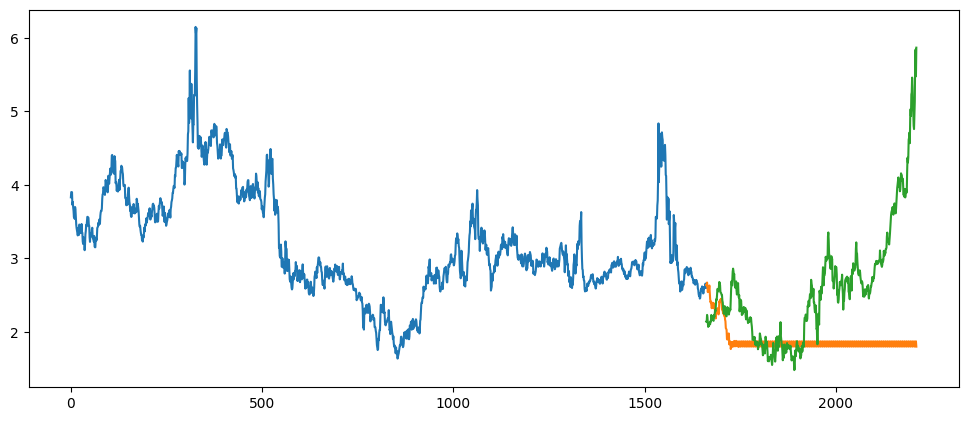

In [ ]:
fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_god[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
plt.plot(fc)
plt.show()

## 4Enc 4Dec

In [38]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
encoder_l3 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs3 = encoder_l3(encoder_outputs1[0])
encoder_states3 = encoder_outputs3[1:]
encoder_l4 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs4 = encoder_l4(encoder_outputs1[0])
encoder_states4 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_l3 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l2,initial_state = encoder_states3)
decoder_l4 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l3,initial_state = encoder_states4)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l4)
#
model_e4d4 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e4d4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 6)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 50, 100),    42800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [39]:
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e4d4.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e4d4=model_e4d4.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=1)

Epoch 1/100


2022-03-23 16:49:37.482956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.139678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.701248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.711861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.839706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.931765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:38.979972: I tensorflow/core/grappler/optimizers/cust

50/50 [==============================] - ETA: 0s - loss: 5.4173

2022-03-23 16:49:48.594497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:48.810358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:48.875785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:48.883581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:48.971409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:49.015410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:49:49.063524: I tensorflow/core/grappler/optimizers/cust

50/50 [==============================] - 16s 149ms/step - loss: 5.4173 - val_loss: 7.7973
Epoch 2/100
50/50 [==============================] - 4s 85ms/step - loss: 4.8735 - val_loss: 7.2300
Epoch 3/100
50/50 [==============================] - 4s 86ms/step - loss: 4.6846 - val_loss: 6.9469
Epoch 4/100
50/50 [==============================] - 4s 85ms/step - loss: 4.2640 - val_loss: 6.4952
Epoch 5/100
50/50 [==============================] - 4s 85ms/step - loss: 3.9883 - val_loss: 6.4350
Epoch 6/100
50/50 [==============================] - 4s 86ms/step - loss: 4.0481 - val_loss: 6.0362
Epoch 7/100
50/50 [==============================] - 4s 87ms/step - loss: 3.7007 - val_loss: 5.8036
Epoch 8/100
50/50 [==============================] - 4s 90ms/step - loss: 3.6207 - val_loss: 5.6451
Epoch 9/100
50/50 [==============================] - 5s 91ms/step - loss: 3.5708 - val_loss: 5.5472
Epoch 10/100
50/50 [==============================] - 4s 90ms/step - loss: 3.4432 - val_loss: 5.5133
Epoch 11/

In [40]:
init_test = np.expand_dims(test.iloc[-50:, :], axis=0)
for i in range(15):
  pred_init = model_e4d4.predict(init_test[:,-50:,:])
  init_test = np.concatenate((init_test, pred_init), axis = 1)


2022-03-23 16:57:42.500189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:42.715620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:42.800174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:42.809168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:42.927272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:43.002221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-23 16:57:43.056935: I tensorflow/core/grappler/optimizers/cust

In [41]:
init_test.shape

(1, 500, 6)

In [42]:
#MSE
y_god = np.expand_dims(y_test[:500, 0, 0], axis=0)
pred_god = init_test[:, :, 0]
mean_absolute_error(y_god, pred_god)

0.9781957461166382

In [43]:
len(init_test[:, :, 0].tolist()[0])

500

In [44]:
test_index = []
for i in range(1661, 2161):
  test_index.append(i)

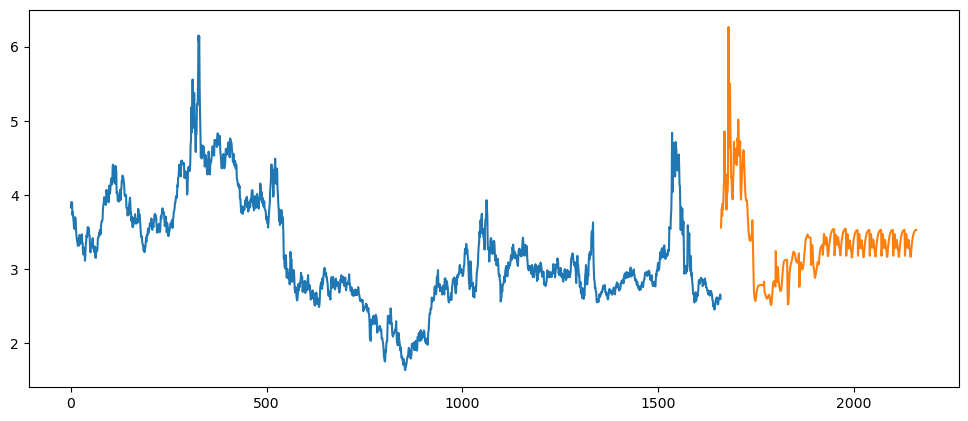

In [45]:
# fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_god[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
# plt.plot(fc)
plt.show()

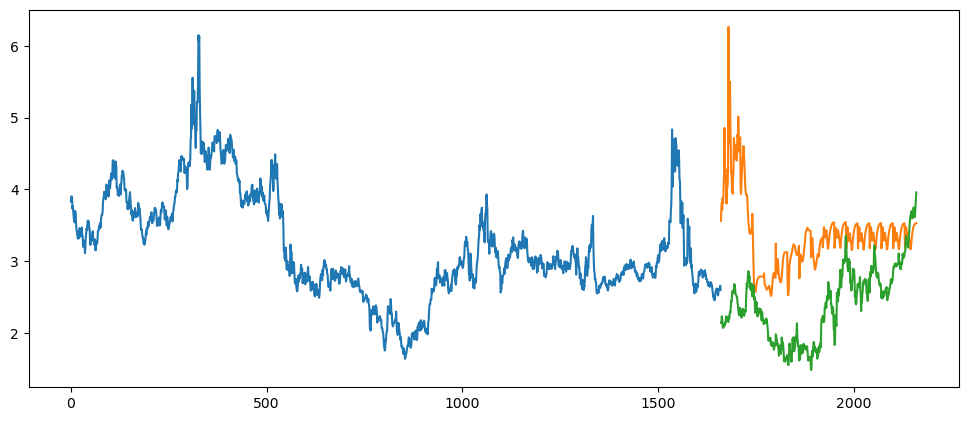

In [46]:
fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_god[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
plt.plot(fc)
plt.show()

In [47]:
model_e4d4.save("/Users/anishpawar/dev/SIH/Repo/Hack_Inversion-SIH/FullApp_v1/V2_App/models/M1model.h5")

In [48]:
model = tf.keras.models.load_model("/Users/anishpawar/dev/SIH/Repo/Hack_Inversion-SIH/FullApp_v1/V2_App/Testing/model_e4d4_v2.h5")

In [49]:
test.iloc[-50:, :]

,Close,Volume,SMA,EMA,MACD,Custom
662,3.561,-1.830119,4.406374,4.302110,0.317233,-54.653066
663,3.730,-2.431006,4.411061,4.294379,0.304265,-42.919384
664,3.815,-2.248114,4.415946,4.287901,0.292733,-37.012832
665,3.717,-1.666339,4.420347,4.280186,0.280285,-43.670882
666,3.882,-2.276305,4.425476,4.274805,0.270270,-32.284526
667,3.812,-1.918441,4.430122,4.268551,0.259646,-37.063364
668,3.916,-1.783569,4.435340,4.263787,0.250629,-29.903937
669,4.079,-1.109079,4.440667,4.261290,0.243909,-18.752906
670,4.249,-2.016429,4.446769,4.261124,0.239499,-7.231114
671,4.857,-0.421211,4.457769,4.269176,0.242840,33.931293


## CNN LSTM

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_past, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(n_future))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

In [ ]:
history_cnn_lstm=model_enc_dec_cnn.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),batch_size=32,verbose=1)

Epoch 1/200
50/50 [==============================] - 19s 170ms/step - loss: 6740.7432 - val_loss: 6168.4785
Epoch 2/200
50/50 [==============================] - 7s 137ms/step - loss: 3589.6902 - val_loss: 4294.2739
Epoch 3/200
39/50 [======================>.......] - ETA: 1s - loss: 3120.0469

In [ ]:
init_test = np.expand_dims(X_test[0], axis=0)
for i in range(10):
  pred_init = model_enc_dec_cnn.predict(init_test[:,-50:,:])
  init_test = np.concatenate((init_test, pred_init), axis = 1)


In [ ]:
#MSE
y_god = np.expand_dims(y_test[:350, 0, 0], axis=0)
pred_god = init_test[:, :, 0]
mean_absolute_error(y_god, pred_god)

0.7589559458214895

In [ ]:
test_index = []
for i in range(1661, 2011):
  test_index.append(i)

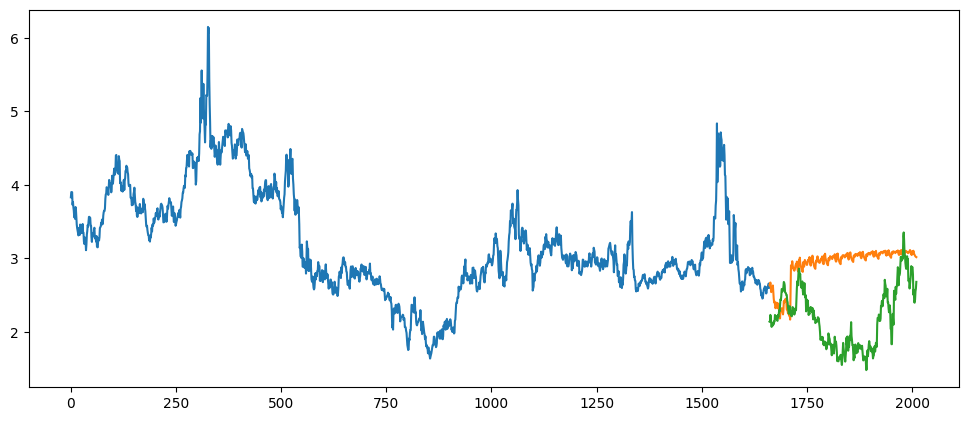

In [ ]:
fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_god[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
plt.plot(fc)
plt.show()

In [ ]:
model_enc_dec_cnn.save("/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/cnn_lstm_v1.h5")